In [2]:
import os
import tensorflow as tf
from PIL import UnidentifiedImageError
from tensorflow.keras.preprocessing.image import (load_img, img_to_array, ImageDataGenerator)
from tensorflow.keras.applications.vgg16 import (preprocess_input, decode_predictions, VGG16)
from tensorflow.keras.layers import (Flatten, Dense, Dropout, BatchNormalization)
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.schedules import ExponentialDecay
from tensorflow.keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from scikeras.wrappers import KerasClassifier


In [3]:
from keras.callbacks import EarlyStopping
from sklearn.model_selection import GridSearchCV


In [ ]:

def grid_search(model, X_train, y_train):
    
    param_grid = {'epochs': [10, 15, 20],
                'batch_size': [16, 32, 64]}

    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 5, n_jobs = -1,
                                scoring = 'accuracy', verbose = 1)

    grid_result = grid_search.fit(X_train, y_train)

    print(f'Best Accuracy for {grid_result.best_score_} using the parameters {grid_result.best_params_}')

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f' mean = {mean:.4}, std = {stdev:.4} using {param}')

    best_estimator = grid_result.best_estimator_

    return best_estimator

In [9]:

def parser():
    """
    The user can specify whether to perform GridSearch, implement batch normalization and/or data augmentation,
    .
    The function will then parse command-line arguments and make them lower case.
    """
    parser = argparse.ArgumentParser()
    parser.add_argument("--GridSearch",
                        "-gs",
                        required = True,
                        choices = ["yes", "no"],
                        help = "Perform GridSearch (yes or no)")
    parser.add_argument("--BatchNorm",
                        "-bn",
                        required = True,
                        choices = ["yes", "no"],
                        help = "Perform batch normalization (yes or no)")   
    parser.add_argument("--DatAug",
                        "-da",
                        required = True,
                        choices = ["yes", "no"],
                        help = "Perform data augmentation (yes or no)")    
    parser.add_argument("--optimizer",
                        "-o",
                        required = True,
                        choices = ["adam", "sgd"],
                        help = "Choose optimizer")              
    args = parser.parse_args()
    args.GridSearch = args.GridSearch.lower()
    args.BatchNorm = args.BatchNorm.lower()
    args.DatAug = args.DatAug.lower()
    args.optimizer = args.optimizer.lower()
    return args


def load_images(folder_path):
    """
    Loads the data from the specified folder path, generates labels for each image, 
    and preprocesses them for model input.
    The dataset contains certain files, i.e., Thumbs.db, could not be loaded and
    returned the error 'UnidentifiedImageError'. These will simplt be ignored.
    """
    list_of_images = [] 
    list_of_labels = []
    
    for subfolder in sorted(os.listdir(folder_path)):
        subfolder_path  = os.path.join(folder_path, subfolder)
        
        for file in os.listdir(subfolder_path):
            individual_filepath = os.path.join(subfolder_path, file)
            
            try:
                image = load_img(individual_filepath, target_size = (224, 224))
                image = img_to_array(image)
                list_of_images.append(image)

                label = subfolder_path.split("/")[-1]
                list_of_labels.append(label)

            except (UnidentifiedImageError):
                print(f"Skipping {individual_filepath}")
        
    array_of_images = np.array(list_of_images)
    X = preprocess_input(array_of_images)
    y = list_of_labels
    
    return X, y


def data_split(X, y):
    """
    Splits the data into training and testing sets by stratifing y.
    Normalizes X to range between 0 and 1 and performs label binarization on y.
    """
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 123)
    X_train = X_train.astype("float32") / 255.
    X_test = X_test.astype("float32") / 255.
    lb = LabelBinarizer()
    y_train = lb.fit_transform(y_train)
    y_test = lb.fit_transform(y_test) 

    return X_train, X_test, y_train, y_test



def define_model(BatchNorm, Optimizer):
    """
    Defines the model architecture. First, the VGG16 model is loaded from TensorFlow without the classification
    layers and the convolutional layers are marked as not trainable to retain their pretrained weights.
    Subsequently, a new fully connected layer with ReLU activation is added followed by an output layer with
    softmax activation for multi-class classification.

    batchNorm option --> user specifies whether the model should be defined with or without batch normalization

    Compiles the model with the specified optimizer ... learning rate 

    """
    model = VGG16(include_top = False, pooling = 'avg', input_shape = (224, 224, 3))

    for layer in model.layers:
        layer.trainable = False

    if BatchNorm == "no":
        flat1 = Flatten()(model.layers[-1].output)
        class1 = Dense(128, activation = 'relu')(flat1)
        output = Dense(10, activation = 'softmax')(class1)

    elif BatchNorm == "yes":
        flat1 = Flatten()(model.layers[-1].output)
        bn = BatchNormalization()(flat1)
        class1 = Dense(128, activation='relu')(bn)
        output = Dense(10, activation='softmax')(class1)
    
    model = Model(inputs = model.inputs, outputs = output)

    # compile
    lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(initial_learning_rate = 0.01, 
                                                                decay_steps = 10000, decay_rate = 0.9)
    if Optimizer == "adam":
        optimizer = Adam(learning_rate = lr_schedule)
    if Optimizer == "sgd":
        optimizer = SGD(learning_rate = lr_schedule)
    model.compile(optimizer = optimizer, loss = 'categorical_crossentropy', metrics = ['accuracy'])

    return model


def sklearn_object(model):
    """
    Convert the model from a KerasClassifier to an object, that can be used in a scikit-learn pipeline.
    """
    model = KerasClassifier(model = model, verbose = 0)
    return model


def data_generator():
    """
    Creates an image data generator with data augmentation settings as horizontal flipping and rotation.
    """
    datagen = ImageDataGenerator(horizontal_flip = True, 
                                rotation_range = 90,
                                validation_split = 0.1)
    return datagen



def fit_model(model, X_train, y_train, DatAug):
    """
    The user specifies whether to implement data augmentation...
    Fits the compiled model to the training data with or without data augmentation and returns the training history.

    early stopping implemented to minimise loss and avoid overfitting. Monitors val_loss
    After 3 epochs with no improvement, the training will be stopped
    """

    callback = [keras.callbacks.EarlyStopping(monitor = "val_loss", patience = 3)]

    if DatAug == "no":
        H = model.fit(X_train, y_train, 
                    validation_split = 0.1,
                    batch_size = 30,
                    epochs = epochs,
                    callbacks = callbacks)
    
    elif DatAug == "yes":
        DatAug = data_generator()
        datagen.fit(X_train)
        H = model.fit(datagen.flow(X_train, y_train, batch_size = BatchSize),
                                    validation_data = datagen.flow(X_train, y_train, 
                                                                    batch_size = BatchSize,
                                                                    subset = "validation"),
                                                                    epochs = epochs,
                                                                    callbacks = callbacks) 
    return H




def plot_history(H, epochs, outpath):
    """
    Plots the training and validation loss and accuracy curves and saves the plot.
    """
    plt.figure(figsize = (12,6))
    plt.subplot(1,2,1)
    plt.plot(np.arange(0, epochs), H.history["loss"], label = "train_loss")
    plt.plot(np.arange(0, epochs), H.history["val_loss"], label = "val_loss", linestyle = ":")
    plt.title("Loss curve")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.tight_layout()
    plt.legend()
    plt.subplot(1,2,2)
    plt.plot(np.arange(0, epochs), H.history["accuracy"], label = "train_acc")
    plt.plot(np.arange(0, epochs), H.history["val_accuracy"], label = "val_acc", linestyle = ":")
    plt.title("Accuracy curve")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.legend()
    plt.show()
    plt.savefig(outpath)


def evaluate(X_test, y_test, model, H, BatchSize, epochs):
    """
    Evaluates the model on the test data, generates classification reports, and saves the results.
    """
    label_names = ["ADVE", "Email", "Form", "Letter", "Memo", "News", "Note", "Report", "Resume", "Scientific"]

    predictions = model.predict(X_test, batch_size = BatchSize)

    classifier_metrics = classification_report(y_test.argmax(axis = 1),
                                               predictions.argmax(axis = 1),
                                               target_names = label_names)

    filepath_metrics = open('out/VGG16_metrics_BatchNorm.txt', 'w')
    filepath_metrics.write(classifier_metrics)
    filepath_metrics.close()

    plot_history(H, epochs, "out/VGG16_losscurve_BatchNorm.png")

    return print("Results have been saved to the out folder")




In [ ]:
def main():
    
    args = parser()

    folder_path = os.path.join("../../../../cds-vis-data/Tobacco3482") # ("in/Tobacco3482")

    X, y = load_images(folder_path)
    X_train, X_test, y_train, y_test = data_split(X, y)
    
    # define model - BatchNorm yes/no
    model = define_model(args.BatchNorm, args.Optimizer)

    # grid search
    if args.GridSearch == 'yes':
        model = sklearn_object(model)
        model = gridsearch(model, X_train, y_train)
    else:
        continue

    # fit model
    H = fit_model(model, X_train, y_train, args.DatAug)
    
    # evaluate
    evaluate(X_test, y_test, model, H)

    # plotter 

if __name__ == "__main__":
    main()

In [10]:
folder_path = os.path.join("../../../../../cds-vis-data/Tobacco3482") # ("in/Tobacco3482")

X, y = load_images(folder_path)
X_train, X_test, y_train, y_test = data_split(X, y)

Skipping ../../../../../cds-vis-data/Tobacco3482/ADVE/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Email/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Form/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Letter/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Memo/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/News/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Note/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Report/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Resume/Thumbs.db
Skipping ../../../../../cds-vis-data/Tobacco3482/Scientific/Thumbs.db


In [11]:
model = define_model("no", "adam")

In [12]:
def fit_model(model, X_train, y_train, DatAug, batch_size = None, epochs = None):

    if batch_size is None:
        batch_size = 32
    if epochs is None:
        epochs = 2

    if DatAug == "no":

        H = model.fit(X_train, y_train,
                      validation_split = 0.1,
                      batch_size = batch_size,
                      epochs = epochs,
                      verbose = 1)

    elif DatAug == "yes":

        datagen = data_generator()
        datagen.fit(X_train)
        H = model.fit(datagen.flow(X_train, y_train, batch_size = batch_size),
                      validation_data = datagen.flow(X_train, y_train,
                                                  batch_size = batch_size,
                                                  subset = "validation"),
                                                  epochs = epochs,
                                                  verbose = 1)

    return H

In [13]:
H = fit_model(model, X_train, y_train, "no", batch_size = None, epochs = None)

Epoch 1/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 403s 5s/step - accuracy: 0.3840 - loss: 1.7830 - val_accuracy: 0.5806 - val_loss: 1.3316
Epoch 2/2
79/79 ━━━━━━━━━━━━━━━━━━━━ 418s 5s/step - accuracy: 0.6006 - loss: 1.1568 - val_accuracy: 0.6237 - val_loss: 1.1264


In [ ]:
import shap

In [ ]:
pip install shap --upgrade

In [17]:
background = X_train[:10] 
explainer = shap.KernelExplainer(model.predict, background)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [ ]:
# Flatten image data
X_test_flattened = X_test[:10].reshape(X_test[:10].shape[0], -1)

# Subset of data as background
background = X_train[:10]  # Choose the size of the subset as needed

# Create a KernelExplainer
explainer = shap.KernelExplainer(model.predict, background)

# Compute SHAP values
shap_values = explainer.shap_values(X_test_flattened)

# Visualize SHAP values
shap.summary_plot(shap_values, X_test_flattened)


In [ ]:
background = X_train[:10] 
explainer = shap.GradientExplainer(model, background)
test_images = X_test[:5]
shap_values = explainer.shap_values(test_images)

In [64]:
X_train.shape

(2785, 224, 224, 3)

In [73]:
explainer = shap.DeepExplainer(model, X_train[0:1])    
    # Choose samples to explain (e.g., first 5 samples)
to_explain = X[:5]

# Compute SHAP values for the chosen samples
shap_values = explainer.shap_values(to_explain)

# Plot the explanations
shap.image_plot(shap_values, to_explain)

/home/ucloud/.local/lib/python3.10/site-packages/shap/explainers/_deep/deep_tf.py:99: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn("Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.")


AttributeError: 'tuple' object has no attribute 'as_list'

In [ ]:
background = X_train[:10]
test_images = X_test[:5]

explainer = shap.DeepExplainer(model, background)
# explainer = shap.GradientExplainer(H, X_train)

shap_values = explainer.shap_values(test_images) # X_test
shap_values = explainer.shap_values(X_test[:5])

# Visualize SHAP values
print(len(shap_values))
shap.summary_plot(shap_values, X_test)

shap_values = e.shap_values(x_test[1:5])
shap.image_plot(shap_values, -x_test[1:5])

In [75]:
from lime import lime_image
from skimage.segmentation import mark_boundaries

Local Interpretable Model-agnostic Explanations = LIME

- explains individual predictions of black-box models by fitting a simpler interpretable model locally around the prediction
- It generates local explanations for specific instances, helping you understand why the model made a particular prediction.

  0%|          | 0/1000 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..128.0].


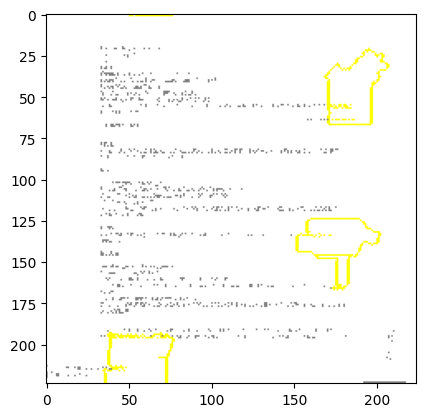

In [80]:
filepath = os.path.join("../../../../../cds-vis-data/Tobacco3482/Email/527970475+-0476.jpg")
#filepath = os.path.join("../../../../../cds-vis-data/Tobacco3482/News/0000644359.jpg")
#filepath = os.path.join("../../../../../cds-vis-data/Tobacco3482/Scientific/10064589_10064594.jpg")

img = image.load_img(filepath, target_size=(224, 224))
x = image.img_to_array(img)

# Create LIME explainer
explainer = lime_image.LimeImageExplainer()

# Explain the prediction
explanation = explainer.explain_instance(x, model.predict, top_labels=5, hide_color=0, num_samples=1000)

# Show explanation
temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=True, num_features=5, hide_rest=False)
plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
plt.savefig("EmailDoc_explained.jpg")
plt.show()


In [28]:
from sklearn.model_selection import GridSearchCV

def grid_search(model, X_train, y_train):
    
    param_grid = {'epochs': [2],
                'batch_size': [16]}

    grid_search = GridSearchCV(estimator = model, param_grid = param_grid, cv = 2, n_jobs = -1,
                                scoring = 'accuracy', verbose = 1)

    grid_result = grid_search.fit(X_train, y_train)

    print(f'Best Accuracy for {grid_result.best_score_} using the parameters {grid_result.best_params_}')

    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
        print(f' mean = {mean:.4}, std = {stdev:.4} using {param}')

    best_estimator = grid_result.best_estimator_

    return best_estimator

In [30]:
import sys, os
sys.path.append("..")
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import (preprocess_input,
                                                 decode_predictions,
                                                 VGG16)

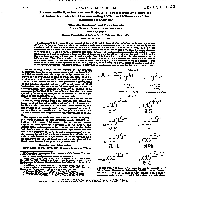

In [57]:
#filepath = os.path.join("../../../../../cds-vis-data/Tobacco3482/Email/527970475+-0476.jpg")
#filepath = os.path.join("../../../../../cds-vis-data/Tobacco3482/News/0000644359.jpg")
filepath = os.path.join("../../../../../cds-vis-data/Tobacco3482/Scientific/10064589_10064594.jpg")

# load image using tf.keras
img = image.load_img(filepath, target_size = (224, 224))
img

In [58]:
x = image.img_to_array(img)
x = np.expand_dims(x, axis = 0)
x = preprocess_input(x)

# make predictions
preds = model.predict(x)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step


In [59]:
with tf.GradientTape() as tape:
    # make sure the name here corresponds to the final conv layer in your network
    last_conv_layer = model.get_layer('block5_conv3')
    
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions    
    iterate = tf.keras.models.Model(model.inputs, 
                                    [model.output, last_conv_layer.output])
    
    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    model_out, last_conv_layer = iterate(x)
    class_out = model_out[:, np.argmax(model_out[0])]
    
    # This is the gradient of the output neuron of the last conv layer
    grads = tape.gradient(class_out, 
                          last_conv_layer)
    # Vector of mean intensity of the gradient over a specific feature map channel
    pooled_grads = K.mean(grads, 
                          axis = (0, 1, 2))

In [60]:
heatmap = tf.reduce_mean(tf.multiply(pooled_grads, last_conv_layer), axis = -1)

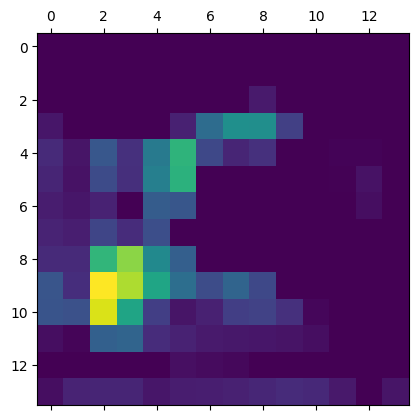

In [61]:
heatmap = np.maximum(heatmap, 0)
heatmap /= np.max(heatmap)
heatmap = heatmap.reshape((14, 14))
plt.matshow(heatmap)
plt.show()

In [62]:
img = cv2.imread(filepath)

# heatmap should be semi transparent
intensity = 0.5

# resize the heatmap to be the original dimensions of the input 
heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

# https://docs.opencv.org/master/d3/d50/group__imgproc__colormap.html
heatmap = cv2.applyColorMap(np.uint8(255*heatmap), cv2.COLORMAP_JET)

# multiply heatmap by intensity and 'add' this on top of the original image
superimposed = (heatmap * intensity) + img

In [63]:
cv2.imwrite("heatmap_scientific.jpg", superimposed)

True